In [41]:
import numpy as np
import pandas as pd
import math
import calendar
from pyproj import Transformer
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot, seasonal_plot
%matplotlib inline

In [17]:
# dataset uploading and transformation
def calculate_coords(x1, y1):
    transformer = Transformer.from_crs("epsg:4647", "epsg:4326")
    x2, y2 = transformer.transform(x1, y1)
    return x2, y2


def upload_dataset():
    df_bsp = pd.read_excel(f'C:/Users/YC/PycharmProjects/nitrateAnalysis/nitrate_lineg_data/'
                           f'Auswertung_GWMSt_komplett.xlsx',
                           header=[14, 15])
    df_bsp.columns = df_bsp.columns.droplevel(1)  # getting rid of multiindex
    df_bsp = df_bsp.iloc[: -3]
    df_bsp_reduced = df_bsp.loc[:, ('Objektnummer', 'Rechtswert', 'Hochwert', 'Probenahmedatum', 'Nitrat (NO#3#)')]
    df_bsp_reduced['Probenahmedatum'] = pd.to_datetime(df_bsp_reduced['Probenahmedatum'],
                                                       format='%d/%m/%Y')
    return df_bsp_reduced


def add_transformed_coords(df_bsp_reduced):
    df = df_bsp_reduced
    locations_dict = dict()
    for object_num in df['Objektnummer'].unique():
        coords_series = df.loc[df['Objektnummer'] == object_num][['Rechtswert', 'Hochwert']].iloc[0]
        rechtswert, hochwert = coords_series[0], coords_series[1]
        lat, lon = calculate_coords(rechtswert, hochwert)
        old_coords_tuple = (rechtswert, hochwert)
        new_coords_tuple = (lat, lon)
        locations_dict[old_coords_tuple] = new_coords_tuple

    for old_coord, new_coord in locations_dict.items():
        df.loc[df['Rechtswert'] == old_coord[0], 'Latitude'] = new_coord[0]
        df.loc[df['Hochwert'] == old_coord[1], 'Longitude'] = new_coord[1]
    return df


df_uploaded = upload_dataset()
df_transformed = add_transformed_coords(df_uploaded)

In [18]:
# data cleaning
def data_cleaning(df_transformed):
    df_transformed_cleaned = df_transformed.replace('NAN', np.nan)
    # detecting LOD values (<0,05)
    mask = df_transformed_cleaned['Nitrat (NO#3#)'].str.contains(r'<', na=False)
    df_transformed_cleaned.loc[mask, 'LOD'] = 'yes'
    df_transformed_cleaned['LOD calculated val'] = df_transformed_cleaned.loc[
        df_transformed_cleaned['LOD'] == 'yes']['Nitrat (NO#3#)'].str.extract('(\d+[,\d]*)')
    # turn 0,05 to 0.05
    df_transformed_cleaned['LOD calculated val'] = df_transformed_cleaned['LOD calculated val'].str.replace(',','.').astype(float)
    # dividing LOD value by qrt(2) to get approximated value
    df_transformed_cleaned.loc[mask, 'Nitrat (NO#3#)'] = (df_transformed_cleaned['LOD calculated val']).astype(float) / math.sqrt(2)
    # transform 'Nitrat (NO#3#)' column type to float, all non-numeric values replace with nans
    df_transformed_cleaned['Nitrat (NO#3#)'] = pd.to_numeric(df_transformed_cleaned['Nitrat (NO#3#)'],
                                                             errors='coerce',
                                                             downcast='float')

    # drop all rows where 'Latitude' is nan
    df_transformed_cleaned = df_transformed_cleaned[df_transformed_cleaned['Latitude'].notna()]
    # drop all rows where 'Longitude' is nan
    df_transformed_cleaned = df_transformed_cleaned[df_transformed_cleaned['Longitude'].notna()]

    return df_transformed_cleaned


df_transformed_cleaned = data_cleaning(df_transformed)


In [187]:
# methods
def merge_df_with_all_years_month_df(df, grouping_column_name, min_year, max_year):
    # create df with all years and month within the time range
    #df.Probenahmedatum.dt.year.min()
    years_range = range(min_year, max_year+1)
    year_month_list = [(year, month, calendar.month_abbr[month])
                                 for year in years_range
                                 for month in range(1, 13)]
    df_all_years_months = pd.DataFrame.from_records(year_month_list,
                                                    columns=['Year', 'MonthNum', 'MonthAbbr'])
   # grouped df with specified nans, separated year and month
    df_merged_all_years_months = pd.merge(
        df_all_years_months, df, how='left', left_on=['Year', 'MonthNum'], right_on=['Year', 'Month'])[['Year', 'MonthNum', 'MonthAbbr', grouping_column_name]]
    # add date, combined year and month
    df_merged_all_years_months['Date'] = pd.to_datetime(df_merged_all_years_months.Year.astype(str) + '-' + df_merged_all_years_months.MonthNum.astype(str))

    df_merged_all_years_months = df_merged_all_years_months.set_index('Date')

    return df_merged_all_years_months

def merge_df_with_all_stations_years_month_df(df, min_year, max_year, *grouping_column_name):
    columns_names = ['Objektnummer', 'Year', 'MonthNum', 'MonthAbbr']
    columns_names += grouping_column_name
    object_nums = df['Objektnummer'].unique().tolist()
    years_range = range(min_year, max_year+1)
    objectnum_year_month_list = [(object, year, month, calendar.month_abbr[month])
                             for object in object_nums
                             for year in years_range
                             for month in range(1, 13)]
    df_all_stations_years_months = pd.DataFrame.from_records(objectnum_year_month_list,
                                                    columns=['Objektnummer', 'Year',
                                                             'MonthNum', 'MonthAbbr'])

    df_merged_all_stations_years_months = pd.merge(
        df_all_stations_years_months, df, how='left', left_on=['Objektnummer', 'Year', 'MonthNum'], right_on=[df.Objektnummer,df['Year'], df['Month']])[columns_names]

    # add date, combined year and month
    df_merged_all_stations_years_months['Date'] = pd.to_datetime(df_merged_all_stations_years_months.Year.astype(str) + '-' + df_merged_all_stations_years_months.MonthNum.astype(str))

    df_merged_all_stations_years_months = df_merged_all_stations_years_months.set_index('Date')

    return df_merged_all_stations_years_months

def calc_num_missing_vals_per_station(df_transformed_cleaned):
    series_mean_per_station_month = df_transformed_cleaned.groupby(
       [df_transformed_cleaned['Objektnummer'],
       df_transformed_cleaned.Probenahmedatum.dt.year,
       df_transformed_cleaned.Probenahmedatum.dt.month])['Nitrat (NO#3#)'].mean('Nitrat (NO#3#)')
    df_mean_per_station_month = pd.DataFrame({
        'Objektnummer': series_mean_per_station_month.index.get_level_values(0),
        'Year': series_mean_per_station_month.index.get_level_values(1),
        'Month': series_mean_per_station_month.index.get_level_values(2),
        'Nitrat (NO#3#) Mean': series_mean_per_station_month.values})

    df_merged_all_stations_years_months = \
        merge_df_with_all_stations_years_month_df(df_mean_per_station_month,
                                                  df_mean_per_station_month['Year'].min(), df_mean_per_station_month['Year'].max(),
                                                  'Nitrat (NO#3#) Mean')

    series_missing_vals_per_station = df_merged_all_stations_years_months['Nitrat (NO#3#) Mean'].isnull()\
                                                .groupby([df_merged_all_stations_years_months['Objektnummer']])\
                                                .sum().astype(int).sort_values()

    df_missing_vals_per_station = pd.DataFrame({
        'Objektnummer': series_missing_vals_per_station.index,
        'MissingVals Number': series_missing_vals_per_station.values})

    return df_missing_vals_per_station, df_merged_all_stations_years_months

def calc_weighted_mean_per_month(df_transformed_cleaned):
    df_mean_count_per_station_month = df_transformed_cleaned.groupby(
    [df_transformed_cleaned['Objektnummer'],
    df_transformed_cleaned.Probenahmedatum.dt.year,
    df_transformed_cleaned.Probenahmedatum.dt.month])[['Nitrat (NO#3#)', 'Objektnummer']].\
        agg({'Nitrat (NO#3#)':['mean', 'count']})

    df_mean_count_per_station_month.columns = df_mean_count_per_station_month.columns.droplevel(0)

    df_mean_count_per_station_month = pd.DataFrame({
        'Objektnummer': df_mean_count_per_station_month.index.get_level_values(0),
        'Year': df_mean_count_per_station_month.index.get_level_values(1),
        'Month': df_mean_count_per_station_month.index.get_level_values(2),
        'Nitrat (NO#3#) Mean': df_mean_count_per_station_month['mean'],
        'Observations Number': df_mean_count_per_station_month['count']
        })

    df_mean_count_merged_all_stations_years_months = \
        merge_df_with_all_stations_years_month_df(df_mean_count_per_station_month,
                                                  df_mean_count_per_station_month['Year'].min(), df_mean_count_per_station_month['Year'].max(),
                                                  'Nitrat (NO#3#) Mean',
                                                  'Observations Number')

    weighted_mean = lambda x: np.average(x, axis=1,
                                         weights=df_mean_count_merged_all_stations_years_months.loc[x.index, 'Observations Number'])

    df_grouped_mean_count_merged_all_stations_years_months = df_mean_count_merged_all_stations_years_months.groupby(['Year', 'MonthNum'])\
        .agg(weighted_mean=("Nitrat (NO#3#) Mean", weighted_mean))

    return df_grouped_mean_count_merged_all_stations_years_months


def calc_num_observations_per_month(df_transformed_cleaned):
    series_num_observations_per_month = df_transformed_cleaned.groupby(
        [df_transformed_cleaned.Probenahmedatum.dt.year,
        df_transformed_cleaned.Probenahmedatum.dt.month])['Nitrat (NO#3#)'].count()
    df_num_observations_per_month = pd.DataFrame({
        'Year': series_num_observations_per_month.index.get_level_values(0),
        'Month': series_num_observations_per_month.index.get_level_values(1),
        'Observations Number': series_num_observations_per_month.values})

    df_num_observations_with_all_years_month = merge_df_with_all_years_month_df(df_num_observations_per_month, 'Observations Number', df_num_observations_per_month['Year'].min(), df_num_observations_per_month['Year'].max())
    df_num_observations_with_all_years_month['Observations Number'] = \
        df_num_observations_with_all_years_month['Observations Number'].fillna(0)

    return df_num_observations_with_all_years_month

def calc_mean_per_month(df_transformed_cleaned):
    series_nitrate_grouped = df_transformed_cleaned.groupby(
    [df_transformed_cleaned.Probenahmedatum.dt.year, df_transformed_cleaned.Probenahmedatum.dt.month])['Nitrat (NO#3#)'].mean('Nitrat (NO#3#)')
    # split date into year and month, turn to dataframe
    df_nitrate_grouped = pd.DataFrame({'Year': series_nitrate_grouped.index.get_level_values(0),
                                   'Month': series_nitrate_grouped.index.get_level_values(1),
                                   'Nitrat (NO#3#) Mean': series_nitrate_grouped.values})

    return merge_df_with_all_years_month_df(df_nitrate_grouped, 'Nitrat (NO#3#) Mean',
                                            df_nitrate_grouped['Year'].min(),
                                            df_nitrate_grouped['Year'].max())

def observe_missing_vals_per_station(df_transformed_cleaned):
    df_missing_vals_per_station = calc_num_missing_vals_per_station(df_transformed_cleaned)[0]
    total_stations_num = len(df_missing_vals_per_station.index)
    total_num_years = (df_transformed_cleaned.Probenahmedatum.dt.year.max() - df_transformed_cleaned.Probenahmedatum.dt.year.min()) + 1
    notnull_stations_num = len(df_missing_vals_per_station.loc[df_missing_vals_per_station['MissingVals Number'] < total_num_years*12])
    mean_missing_vals_per_station = df_missing_vals_per_station['MissingVals Number'].mean()
    min_missing_vals_per_station = df_missing_vals_per_station['MissingVals Number'].min()
    max_missing_vals_per_station = df_missing_vals_per_station['MissingVals Number'].max()
    sd_missing_vals_per_station = df_missing_vals_per_station['MissingVals Number'].std()

    print(f"Total number of years explored in the dataset: {total_num_years}.")
    print(f"Total number of stations in the dataset: {total_stations_num}.")
    print(f"Total number of stations with at least 1 observation: {notnull_stations_num}.")
    print(f"Min number of missing values per one station: {min_missing_vals_per_station}.")
    print(f"Max number of missing values per one station {max_missing_vals_per_station}.")
    print(f"Mean number of missing values per one station: {mean_missing_vals_per_station}.")
    print(f"Standard deviation of missing values per one station: {sd_missing_vals_per_station}.")
    # plot frequency plot
    sns.histplot(data=df_missing_vals_per_station, x="MissingVals Number").set(title='Distribution of Missing Values of All Stations')
    plt.show()

def plot_observations_num_line_plot(df):
     ax = df['Observations Number'].plot(color="cadetblue", marker='.', markersize=3.5, figsize=(15, 8))
     # create new ticks labels with year-month resolution
     xticks_labels = []
     for xtick in  ax.get_xticklabels():
          xticks_labels.append(xtick.get_text() + '-01')

     # draw line for each year in the plot
     for xc in df['Year'].unique():
         ax.axvline(x=xc.astype(str) + '-01-01', color='black', linewidth=0.5, linestyle='--')

     #draw a thick line in 1987
     ax.axvline(x='1987-01-01', color='red', linewidth=2)
     #write text '1987'
     ax.text(x='1987-01-01', y=-13, s='1987-01',
        verticalalignment='bottom', horizontalalignment='right',
        color='red', fontsize=15)

     ax.set_ylabel('Number of Observations', fontsize=16)
     ax.set_xlabel('Year-month', fontsize=16)
     ax.set_title('Number of Observations across all Stations per Month per Year', loc='center', fontsize=20)

     ticks_loc = ax.get_xticks().tolist()
     ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
     ax.set_xticklabels(xticks_labels)

     plt.show()

def interpolate_missing_vals(df_nitrate_grouped_all_years_months):
    df_nitrate_grouped_all_years_months_interp = df_nitrate_grouped_all_years_months.copy()
    df_nitrate_grouped_all_years_months_interp['LinearInter'] = df_nitrate_grouped_all_years_months_interp['Nitrat (NO#3#) Mean'].interpolate(method="linear")
    df_nitrate_grouped_all_years_months_interp.loc[df_nitrate_grouped_all_years_months_interp['Nitrat (NO#3#) Mean'].isna(), 'OnlyInterVals'] = \
    df_nitrate_grouped_all_years_months_interp.loc[df_nitrate_grouped_all_years_months_interp['Nitrat (NO#3#) Mean'].isna(), 'LinearInter']

    return df_nitrate_grouped_all_years_months_interp

def plot_time_series(df_nitrate_grouped_interp):
    ax=df_nitrate_grouped_interp["LinearInter"].plot(color="lightcoral", marker='.', markersize=3.5, figsize=(15, 8))
    ax=df_nitrate_grouped_interp["Nitrat (NO#3#) Mean"].plot(marker='.', markersize=3.5, color='cadetblue')

    # create new ticks labels with year-month resolution
    xticks_labels = []
    for xtick in  ax.get_xticklabels():
        xticks_labels.append(xtick.get_text() + '-01')

    # draw line for each year in the plot
    for xc in df_nitrate_grouped_interp['Year'].unique():
        ax.axvline(x=xc.astype(str) + '-01-01', color='black', linewidth=0.5, linestyle='--')

    ax.legend(["Interpolated values", "Actual values"])
    ax.set_ylabel('Nitrat (NO#3#) Mean (mg/l)', fontsize=16)
    ax.set_xlabel('Year-month', fontsize=16)
    ax.set_title('Mean Nitrate Concentration per Month per Year', loc='center', fontsize=20)

    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_xticklabels(xticks_labels)

    plt.show()


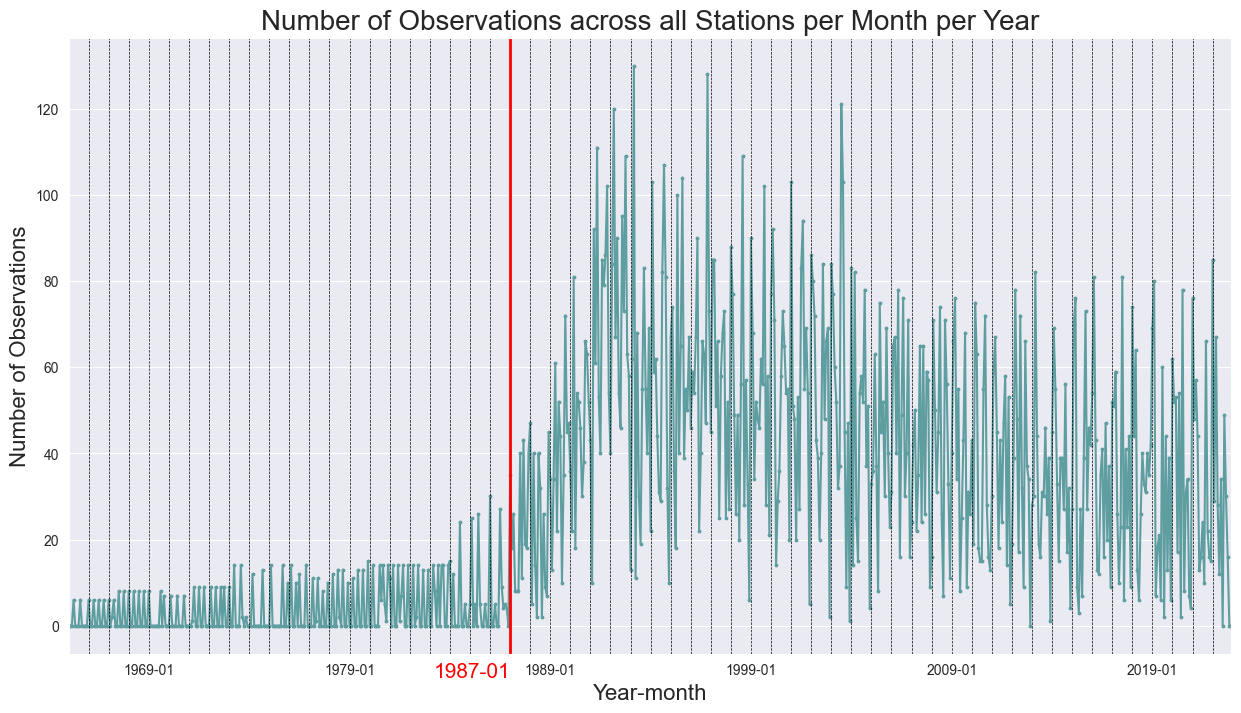

Percentage of null observations in the dataset: 0.24281609195402298.
Percentage of null observations in the cut dataset (from 1987): 0.009259259259259259.
Min number of observations made from 1987 till 2022: 0.0.
Max number of observations made from 1987 till 2022 130.0.
Mean number of observations made from 1987 till 2022: 44.238425925925924.
Standard deviation of observations made from 1987 till 2022: 26.477168824824513.


In [105]:
# explore number of observations
df_num_observations_all_years_months = calc_num_observations_per_month(df_transformed_cleaned)
plot_observations_num_line_plot(df_num_observations_all_years_months)
# percent of 0 observations in the dataset
missing_observ = df_num_observations_all_years_months[df_num_observations_all_years_months['Observations Number'] == 0].count(axis=0)['Observations Number']/len(df_num_observations_all_years_months.index)
print(f"Percentage of null observations in the dataset: {missing_observ}.")
# select only vals from 1987
df_num_observations_from_1987 = df_num_observations_all_years_months.loc[df_num_observations_all_years_months['Year'] > 1986]
# percent of 0 observations in the cut dataset (from 1987)
missing_observ_from_1987 = df_num_observations_from_1987[df_num_observations_from_1987['Observations Number'] == 0].count(axis=0)['Observations Number']/len(df_num_observations_from_1987.index)
print(f"Percentage of null observations in the cut dataset (from 1987): {missing_observ_from_1987}.")
# statistics on the cut dataset (from 1987)
mean_observ_from_1987 = df_num_observations_from_1987['Observations Number'].mean()
min_observ_from_1987 = df_num_observations_from_1987['Observations Number'].min()
max_observ_from_1987 = df_num_observations_from_1987['Observations Number'].max()
sd_observ_from_1987 = df_num_observations_from_1987['Observations Number'].std()
print(f"Min number of observations made from 1987 till 2022: {min_observ_from_1987}.")
print(f"Max number of observations made from 1987 till 2022 {max_observ_from_1987}.")
print(f"Mean number of observations made from 1987 till 2022: {mean_observ_from_1987}.")
print(f"Standard deviation of observations made from 1987 till 2022: {sd_observ_from_1987}.")

Observing missing values for each station (1965-2022)
Total number of years explored in the dataset: 58.
Total number of stations in the dataset: 1024.
Total number of stations with at least 1 observation: 941.
Min number of missing values per one station: 495.
Max number of missing values per one station 696.
Mean number of missing values per one station: 676.9140625.
Standard deviation of missing values per one station: 27.060636402752877.


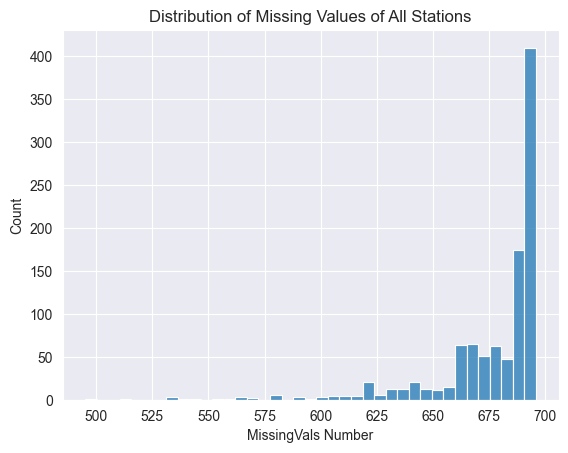

Observing missing values for each station (1987-2022)
Total number of years explored in the dataset: 36.
Total number of stations in the dataset: 1024.
Total number of stations with at least 1 observation: 941.
Min number of missing values per one station: 231.
Max number of missing values per one station 432.
Mean number of missing values per one station: 413.8798828125.
Standard deviation of missing values per one station: 24.381583389689936.


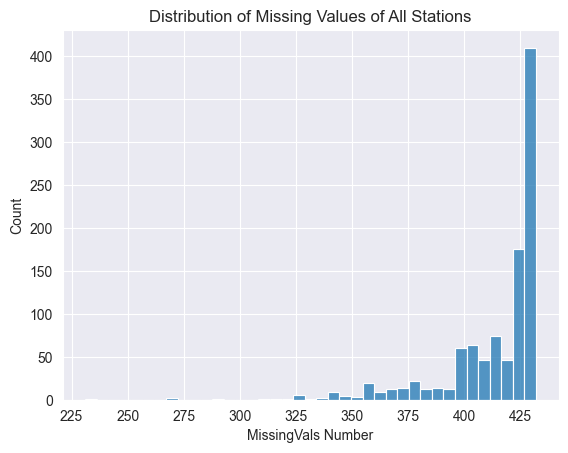

Time series plot for the station #858 (1987-2022)


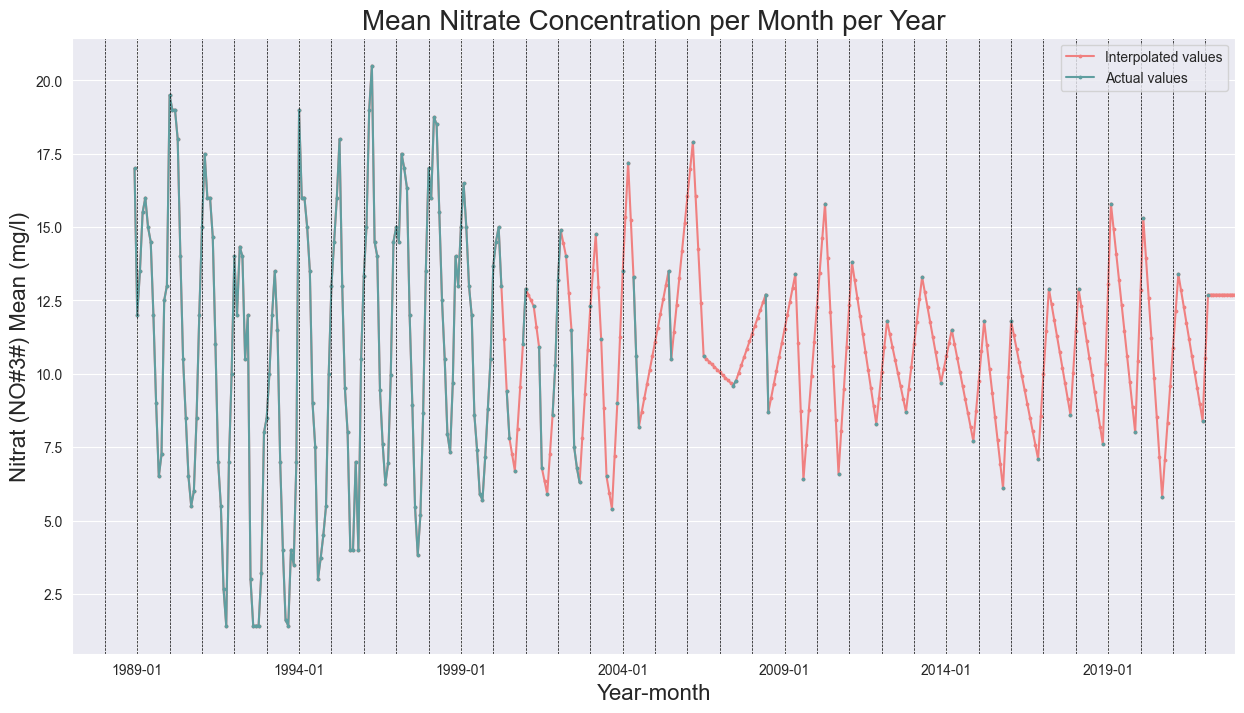

In [188]:
# explore missing values per each station
print('Observing missing values for each station (1965-2022)')
observe_missing_vals_per_station(df_transformed_cleaned)

# explore missing values per each station (from 1987)
print('Observing missing values for each station (1987-2022)')
df_transformed_cleaned_from_1987 = df_transformed_cleaned.loc[df_transformed_cleaned.Probenahmedatum.dt.year > 1986]
observe_missing_vals_per_station(df_transformed_cleaned_from_1987)

# explore station with the smallest number of missing values (from 1987)
df_missing_vals_per_station, df_merged_all_stations_years_months = calc_num_missing_vals_per_station(df_transformed_cleaned_from_1987)
# station #858 has the smallest value of missing values - 231
df_station858 = df_merged_all_stations_years_months.loc[df_merged_all_stations_years_months['Objektnummer'] == 858]
df_station858_interp = interpolate_missing_vals(df_station858)
print('Time series plot for the station #858 (1987-2022)')
plot_time_series(df_station858_interp)

In [109]:
# group data by month, add nans for missing values

df_nitrate_grouped_all_years_months = calc_mean_per_month(df_transformed_cleaned)

In [110]:
# linear interpolation of missing values
df_nitrate_grouped_all_years_months_interp = interpolate_missing_vals(df_nitrate_grouped_all_years_months)

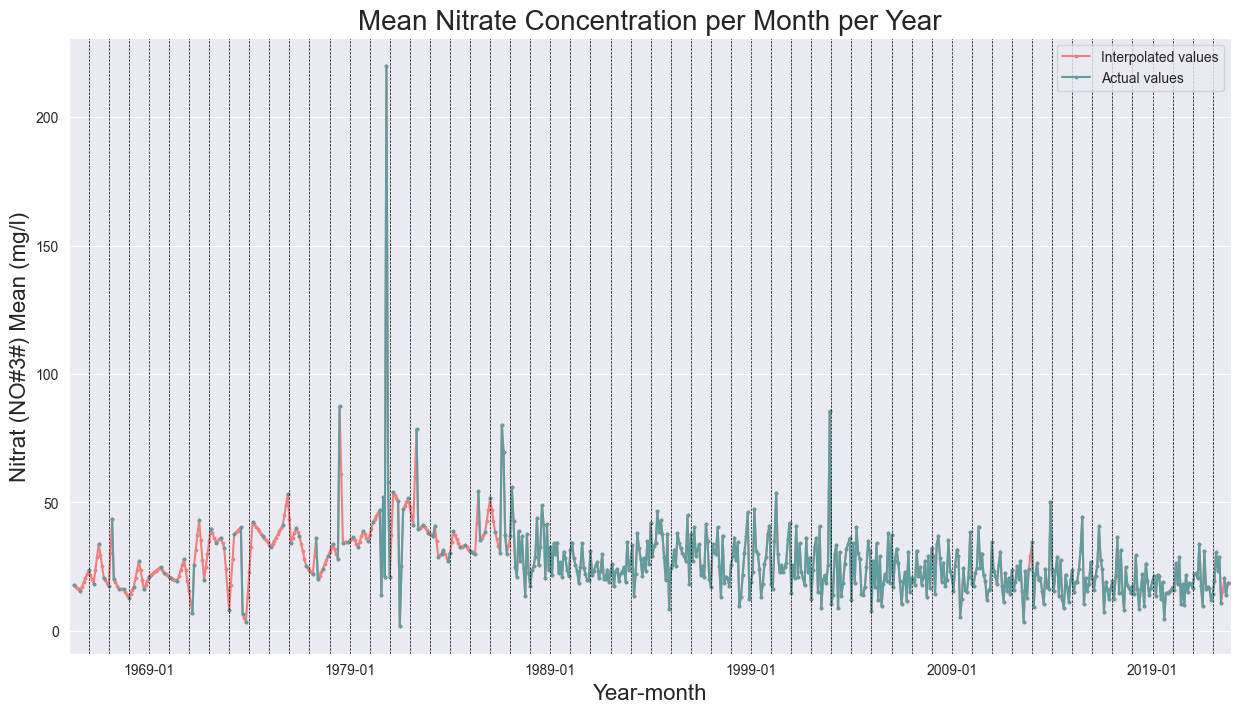

In [111]:
# time series line plot
plot_time_series(df_nitrate_grouped_all_years_months_interp)

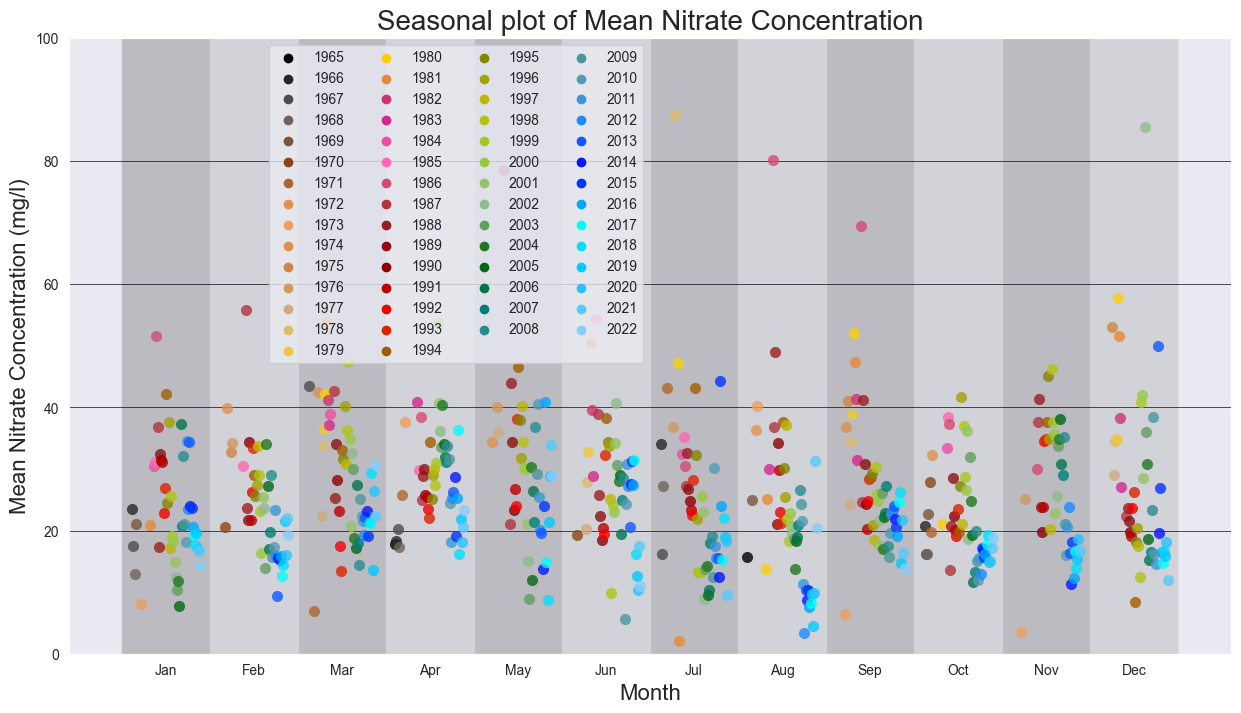

In [40]:
# seasonal plot

def seasonal_plot():
    fig, ax = plt.subplots(figsize=(15, 8))
    palette = sns.color_palette('blend:black,dimgrey,saddlebrown,sandybrown,peru,tan,gold,mediumvioletred,hotpink,brown,maroon,red,olive,y,yellowgreen,darkseagreen,darkgreen,teal,'
                                'cadetblue,dodgerblue,blue,cyan,deepskyblue,lightskyblue', 58)

    sns.stripplot(x="MonthAbbr", y="Nitrat (NO#3#) Mean", hue="Year",
                  data=df_nitrate_grouped_all_years_months, palette=palette, dodge=True,
                  size=8, alpha=0.8)
    # drop outliers in plot
    ax.set_ylim(0, 100)
    # draw vertical lines (shadowed zones)
    for x in range(0, len(df_nitrate_grouped_all_years_months_interp['MonthAbbr'].unique())):
        ax.axvspan(x - 0.5, x + 0.5, facecolor='black', alpha=[0.2 if x % 2 == 0 else 0.1][0])
    # draw horizontal lines
    for y in ax.get_yticks():
        ax.axhline(y=y, color='black', linewidth=0.5, linestyle='-')

    ax.set_title('Seasonal plot of Mean Nitrate Concentration', loc='center', fontsize=20)
    ax.set_xlabel('Month', fontsize=16)
    ax.set_ylabel('Mean Nitrate Concentration (mg/l)', fontsize=16)
    ax.legend(bbox_to_anchor=(0.5, 1), loc=1, ncol=4)
    plt.show()

seasonal_plot()

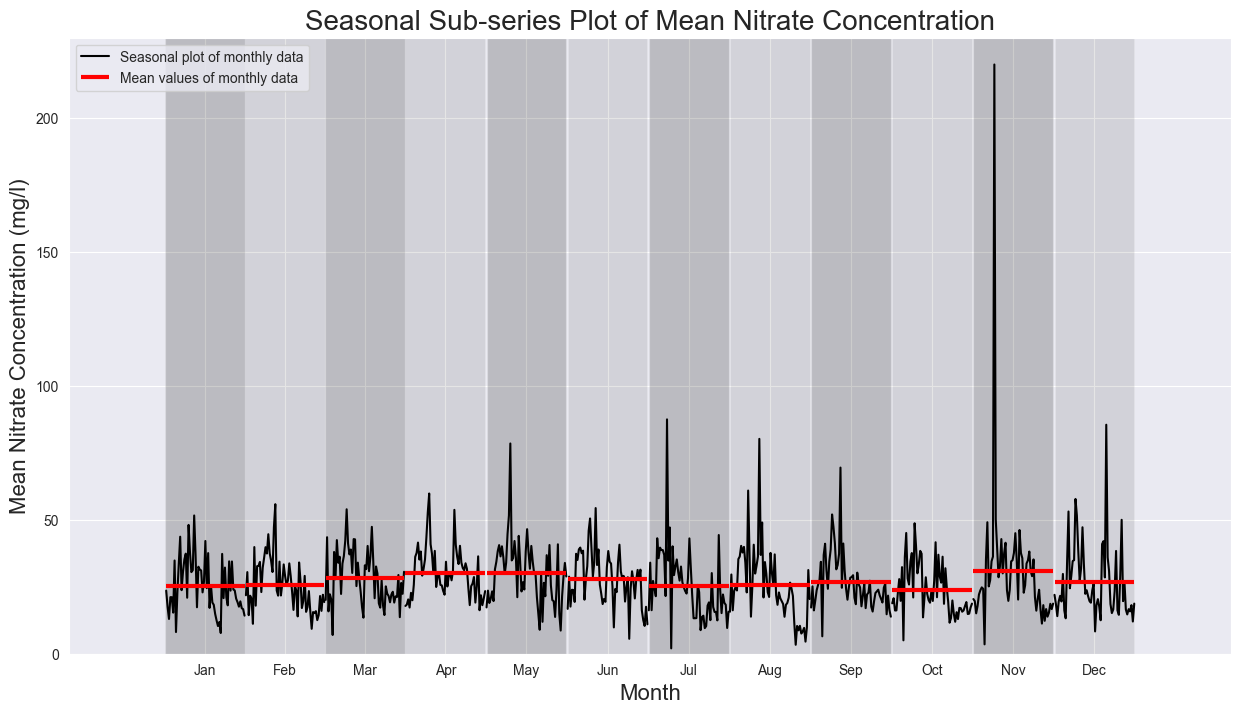

In [43]:
# seasonal sub-series plot
def seasonal_sub_series_plot():
    fig, ax = plt.subplots(figsize=(15, 8))

    # month_plot doesn't support nans, drop nans
    analysis = df_nitrate_grouped_all_years_months_interp[['LinearInter']].copy()
    analysis.dropna(inplace=True)

    month_plot(analysis['LinearInter'], ylabel='Mean Nitrate Concentration', ax=ax)
    spacing = ax.get_xticks()[0] + 0.5
    for idx, x in enumerate(ax.get_xticks()):
        ax.axvspan(x - spacing, x + spacing, facecolor='black', alpha=[0.2 if idx % 2 == 0 else 0.1][0])

    ax.set_ylim(0, 230)
    ax.set_title('Seasonal Sub-series Plot of Mean Nitrate Concentration', loc='center', fontsize=20)
    ax.set_xlabel('Month', fontsize=16)
    ax.set_ylabel('Mean Nitrate Concentration (mg/l)', fontsize=16)
    ax.legend(['Seasonal plot of monthly data', "Mean values of monthly data"])
    plt.show()

seasonal_sub_series_plot()

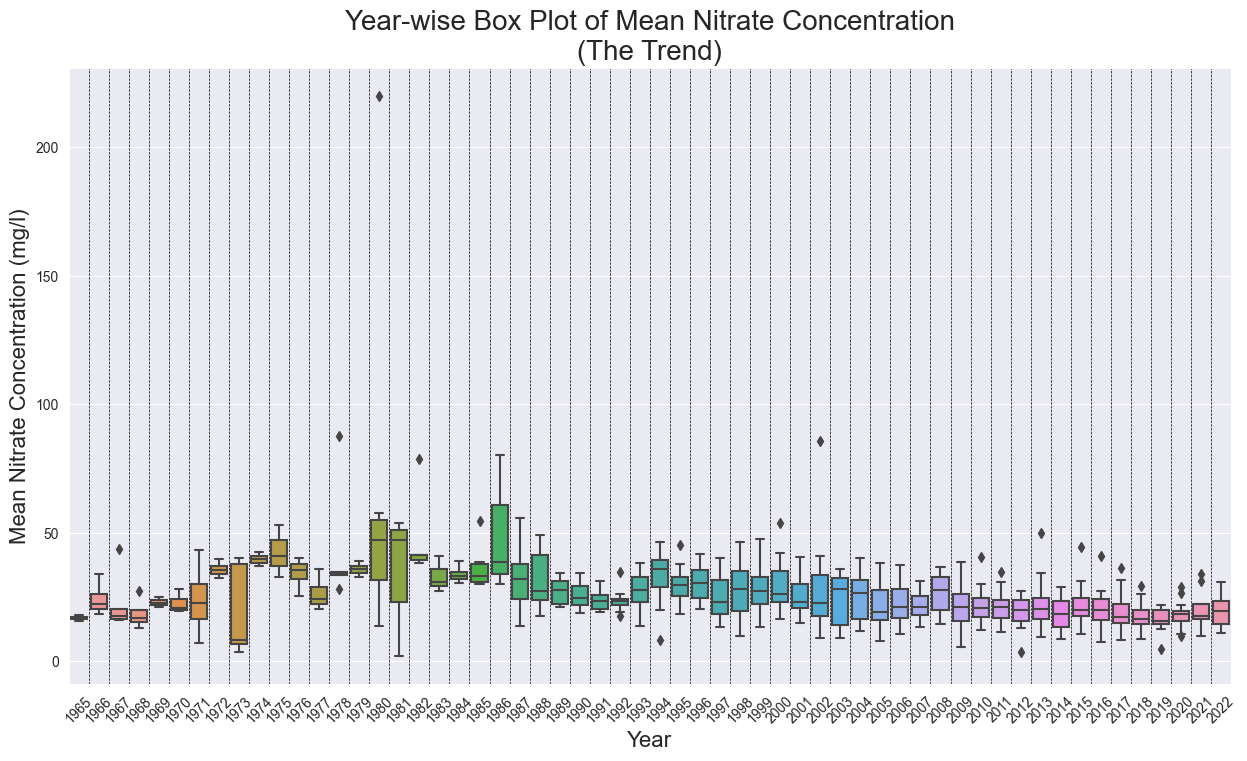

In [47]:
# seasonal sub-series box plot (for trend)
def seasonal_sub_series_boxplot():
    fig, ax = plt.subplots(figsize=(15, 8))

    sns.boxplot(x=df_nitrate_grouped_all_years_months_interp['Year'],
                y=df_nitrate_grouped_all_years_months_interp['Nitrat (NO#3#) Mean'], ax=ax)
    ax.set_title('Year-wise Box Plot of Mean Nitrate Concentration\n(The Trend)', fontsize=20, loc='center')
    ax.set_xlabel('Year', fontsize=16)
    ax.set_ylabel('Mean Nitrate Concentration (mg/l)', fontsize=16)
    ax.tick_params(axis='x', rotation=45)
    spacing = ax.get_xticks()[0] + 0.5
    for xc in ax.get_xticks():
        ax.axvline(x=xc + spacing, color='black', linewidth=0.5, linestyle='--')
    plt.show()

seasonal_sub_series_boxplot()